In [202]:
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [203]:
df = pd.read_csv('PRSA_data.csv')

df = df.drop(['Ir','No','Is'],axis = 1)

#Changing the column names
cnames = list(df.columns)

#Drop the first row 
df = df[24:]

df.dtypes

df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

df_new = df[['year', 'month', 'day', 'hour']]
df_new['date'] = pd.to_datetime(df_new)

df['date'] = df_new['date']

#Set the date as Index
df = df.set_index(df['date'],drop = False)
df = df.sort_index()

# df_cbwd = df['cbwd']
# df_cbwd['cbwd_mode'] = df_cbwd.resample("d").apply(lambda x: stats.mode(x)[0])

# df = df.resample('d').mean()
# df['cbwd'] = df_cbwd['cbwd_mode']

df['day_of_week'] = df.index.dayofweek

def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df['weekend'] = df['day_of_week'].apply(weekend)


mean = df['pm2.5'].min()
std_dev = df['pm2.5'].max() - df['pm2.5'].min()

for field in cnames:
    print(field, df[field].isna().sum())

df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

df = pd.get_dummies(df, columns = ['cbwd'] )    

df['PM2.5'] = df['pm2.5']
df = df.drop(['pm2.5'], axis = 1)

df = df.drop(['hour', 'date'], axis = 1)

cnames = list(df.columns)

year 0
month 0
day 0
hour 0
pm2.5 2043
DEWP 0
TEMP 0
PRES 0
cbwd 0
Iws 0


In [204]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,-16,-4.0,1020.0,1.79,5,1,0,0,1,0,129.0
2010-01-02 01:00:00,2010,1,2,-15,-4.0,1020.0,2.68,5,1,0,0,1,0,148.0
2010-01-02 02:00:00,2010,1,2,-11,-5.0,1021.0,3.57,5,1,0,0,1,0,159.0
2010-01-02 03:00:00,2010,1,2,-7,-5.0,1022.0,5.36,5,1,0,0,1,0,181.0
2010-01-02 04:00:00,2010,1,2,-7,-5.0,1022.0,6.25,5,1,0,0,1,0,138.0


In [205]:
df = df.resample('d').mean()

In [206]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,2010.0,1.0,2.0,-8.500000,-5.125000,1024.750000,24.860000,5.0,1.0,0.000,0.000000,1.00,0.000000,145.958333
2010-01-03,2010.0,1.0,3.0,-10.125000,-8.541667,1022.791667,70.937917,6.0,1.0,0.000,0.166667,0.75,0.083333,78.833333
2010-01-04,2010.0,1.0,4.0,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,0.000,1.000000,0.00,0.000000,31.333333
2010-01-05,2010.0,1.0,5.0,-24.583333,-14.458333,1033.625000,56.920000,1.0,0.0,0.375,0.583333,0.00,0.041667,42.458333
2010-01-06,2010.0,1.0,6.0,-23.708333,-12.541667,1033.750000,18.511667,2.0,0.0,0.500,0.416667,0.00,0.083333,56.416667


In [207]:
df = df.iloc[:-2,:]

In [208]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

for field in cnames:
    df[field] = (df[field] - df[field].min())/(df[field].max() - df[field].min())

# choose a number of time steps
n_steps_in, n_steps_out = 15, 4

X, y = split_sequences(df.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

for i in range(n_steps_out):
	X = np.delete(X, X.shape[0] - 1, 0)
	y = np.delete(y, y.shape[0] - 1, 0)

n_features = X.shape[2]
X_svr = X[:,:,0]

In [209]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,0.0,0.0,0.033333,0.417075,0.197183,0.621417,0.050777,0.833333,1.0,0.000000,0.000000,1.00,0.000000,0.269502
2010-01-03,0.0,0.0,0.066667,0.389783,0.125000,0.581788,0.150561,1.000000,1.0,0.000000,0.166667,0.75,0.083333,0.142996
2010-01-04,0.0,0.0,0.100000,0.209237,0.062500,0.713322,0.237666,0.000000,0.0,0.000000,1.000000,0.00,0.000000,0.053476
2010-01-05,0.0,0.0,0.133333,0.146956,0.000000,0.801012,0.120205,0.166667,0.0,0.391304,0.583333,0.00,0.041667,0.074443
2010-01-06,0.0,0.0,0.166667,0.161652,0.040493,0.803541,0.037029,0.333333,0.0,0.521739,0.416667,0.00,0.083333,0.100749


In [210]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# regr_multirf = MultiOutputRegressor(SVR(kernel='rbf'))

regr_multirf = MultiOutputRegressor(estimator=SVR(kernel='rbf', degree = 5))
regr_multirf.fit(X_svr, y)

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=5,
                                   epsilon=0.1, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                     n_jobs=None)

In [211]:
X_test.shape

(15, 13)

In [212]:
X_test = X_test.reshape((1, n_steps_in, n_features))
X_test_new = X_test[:,:,0]
yhat = regr_multirf.predict(X_test_new)

In [213]:
print(X_test_new.shape)
print(yhat.shape)

(1, 15)
(1, 4)


In [214]:
print(yhat.shape)
print(y_test.shape)

(1, 4)
(4,)


In [215]:
X.shape

(1802, 15, 13)

In [216]:
yhat = (yhat[0]*std_dev)+mean
y_test = (y_test*std_dev)+mean
print(yhat)
print(y_test)

[156.3439851  156.83974768 155.97740506 154.39846108]
[313.39075108 441.55703085 364.20454409 292.31590605]


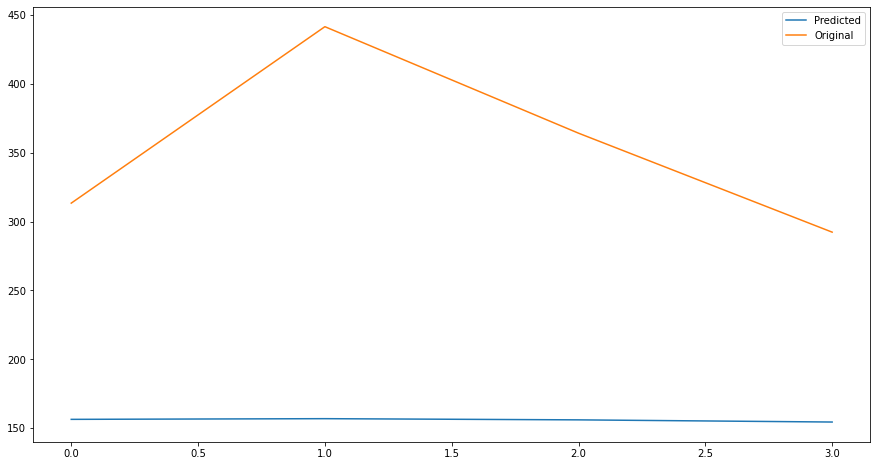

In [217]:
#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

# fig, ax = plt.subplots()
plt.plot(yhat, label = 'Predicted')
plt.plot(y_test, label = 'Original')
plt.legend()
plt.show()

In [218]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test, yhat))
print(rms_new)

mse_new = mean_squared_error(y_test, yhat)
print(mse_new)

mae_new = mean_absolute_error(y_test, yhat)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test, yhat)
print(mape_new)

205.0045006176519
42026.845273492836
196.97715828717233
54.73662760309141
